# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

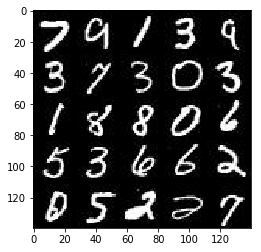

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

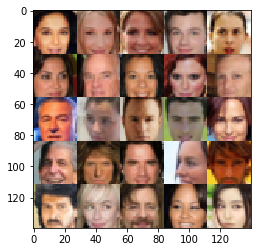

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='z_dim')
    lr = tf.placeholder(tf.float32)
    return inputs, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # images is 28x28x?
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(x1 * alpha, x1)
        # 14x14x64
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2* alpha, x2)
        # 7x7x128
        x3 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3* alpha, x3)
        # ?x?x256
        # Flatten
        x4 = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(x4, 1)
        out = tf.nn.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # z to 4x4x512
        x1 = tf.layers.dense(z, 2*2*512)
        # reshape 
        x1 = tf.reshape(x1, (-1,2,2,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # now 3x3x512
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # now 7x7x256
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # now 14x14x128
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # now 28x28x?
        out = tf.tanh(logits)
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    model_fake = generator(input_z, out_channel_dim, is_train=True)
    real_out, real_logits = discriminator(input_real)
    fake_out, fake_logits = discriminator(model_fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=real_logits, labels=tf.ones_like(real_out)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=fake_logits, labels=tf.zeros_like(fake_out)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=fake_logits, labels=tf.ones_like(fake_out)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    inputs, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    d_loss, g_loss = model_loss(inputs, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every = 5
    show_every = 100
    show_n_images = 25
    steps = 0
    print_head = False
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                batch_images*=2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={inputs: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    if not print_head:
                        print("Epoch {}/{} S(D,G) ".format(epoch_i, epoch_count), end='')
                        print_head = True
                    d_loss_val = d_loss.eval({input_z: batch_z, inputs: batch_images})
                    g_loss_val = g_loss.eval({input_z: batch_z})
                    print("{}({:.4f} {:.4f}) ".format(steps, d_loss_val, g_loss_val), end='')
                if steps % show_every == 0:
                    print('')
                    print_head = False
                    show_generator_output(sess, show_n_images, input_z, img_channels, data_image_mode)
        print("\nDone!")
        show_generator_output(sess, show_n_images, input_z, img_channels, data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 0/2 S(D,G) 5(1.4089 0.4624) 10(1.2699 1.4572) 15(1.2487 1.4505) 20(1.5356 1.3446) 25(0.9744 0.8095) 30(1.1471 0.6492) 35(1.1018 1.1553) 40(0.9997 0.8633) 45(1.2146 0.9870) 50(1.1305 0.7705) 55(1.3832 0.9432) 60(1.2995 1.7511) 65(1.2810 1.1311) 70(1.1569 1.1749) 75(1.1249 0.5816) 80(1.4373 1.3890) 85(1.2311 1.2422) 90(1.1739 1.4342) 95(1.2883 0.5191) 100(1.1485 1.0894) 


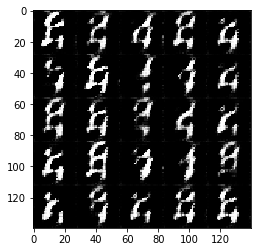

Epoch 0/2 S(D,G) 105(1.4830 0.5224) 110(1.1704 1.0107) 115(1.0272 1.5946) 120(0.9226 1.1971) 125(1.3295 1.1054) 130(1.3222 0.8574) 135(1.2325 1.3545) 140(1.0826 0.7584) 145(1.1007 1.2286) 150(1.2231 1.1063) 155(1.0486 0.8552) 160(1.1570 0.7123) 165(1.1280 0.8884) 170(1.3728 1.5744) 175(1.3023 0.6182) 180(1.4885 0.8839) 185(1.2699 0.8873) 190(1.3277 0.8958) 195(1.2511 0.7205) 200(1.3788 1.3151) 


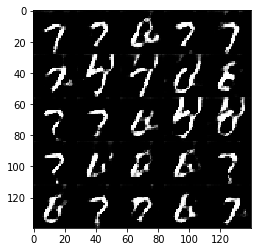

Epoch 0/2 S(D,G) 205(1.4024 0.4173) 210(1.2745 0.9688) 215(1.3621 0.6465) 220(1.1901 0.9426) 225(1.2331 0.7628) 230(1.3364 0.6345) 235(1.2646 0.7961) 240(1.2458 0.7630) 245(1.3426 0.8782) 250(1.4196 0.4292) 255(1.4527 1.1239) 260(1.3220 0.5203) 265(1.3123 0.7475) 270(1.4069 1.3856) 275(1.3054 0.8315) 280(1.3514 0.6088) 285(1.3633 1.1600) 290(1.3318 0.6093) 295(1.2641 0.7831) 300(1.3896 0.6853) 


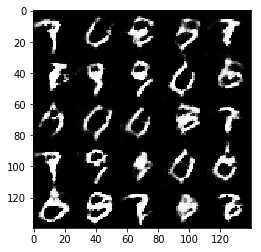

Epoch 0/2 S(D,G) 305(1.4507 0.9864) 310(1.4783 0.6052) 315(1.1972 0.8026) 320(1.4217 1.1555) 325(1.3370 0.6924) 330(1.2989 0.6138) 335(1.3974 1.3098) 340(1.2998 0.5737) 345(1.3359 0.8095) 350(1.2879 0.9377) 355(1.4268 0.4686) 360(1.3013 0.9077) 365(1.3577 0.5183) 370(1.3410 0.9086) 375(1.3813 0.9181) 380(1.3238 0.8596) 385(1.2175 1.0954) 390(1.3456 0.6226) 395(1.3425 1.0933) 400(1.3946 0.5293) 


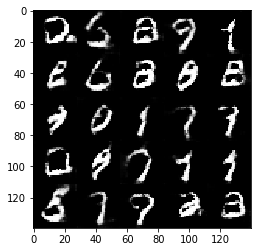

Epoch 0/2 S(D,G) 405(1.3362 1.0273) 410(1.3303 0.5092) 415(1.3044 0.8399) 420(1.3876 0.5864) 425(1.2982 0.7769) 430(1.3778 0.8652) 435(1.3440 0.5565) 440(1.3960 1.0206) 445(1.2792 0.6904) 450(1.4481 0.9142) 455(1.2844 0.6293) 460(1.2977 0.9002) 465(1.2578 0.6890) 470(1.3965 1.1201) 475(1.3924 1.1246) 480(1.4230 0.4673) 485(1.2890 0.7150) 490(1.4215 1.2804) 495(1.2372 0.7882) 500(1.4057 0.6056) 


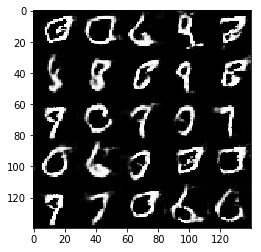

Epoch 0/2 S(D,G) 505(1.2425 0.7815) 510(1.3438 0.6748) 515(1.2999 0.5974) 520(1.3841 1.2058) 525(1.2634 0.7602) 530(1.3492 0.8326) 535(1.3802 0.5083) 540(1.4124 0.9011) 545(1.4156 0.5231) 550(1.3652 0.9643) 555(1.3192 0.6572) 560(1.5815 1.3669) 565(1.2972 0.6850) 570(1.4403 1.1748) 575(1.3401 0.5884) 580(1.3285 0.7536) 585(1.3702 0.5238) 590(1.4729 1.2075) 595(1.3394 0.5527) 600(1.3068 0.7574) 


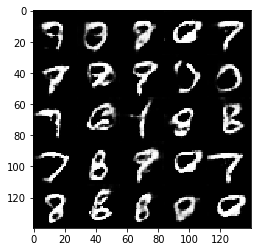

Epoch 0/2 S(D,G) 605(1.3104 0.7872) 610(1.2858 0.7431) 615(1.3098 0.6149) 620(1.3089 0.9546) 625(1.2776 0.8125) 630(1.2911 0.6944) 635(1.3088 0.9072) 640(1.4579 0.4519) 645(1.3632 1.0296) 650(1.4677 0.7876) 655(1.3074 0.7967) 660(1.3383 0.5814) 665(1.2225 0.8005) 670(1.3594 0.6255) 675(1.2875 0.8382) 680(1.3855 0.5866) 685(1.3054 0.7458) 690(1.3753 1.0943) 695(1.2859 0.6623) 700(1.2608 0.7644) 


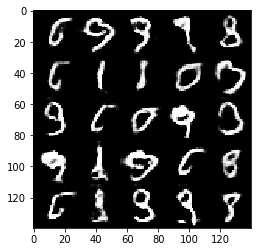

Epoch 0/2 S(D,G) 705(1.3760 1.0369) 710(1.3114 0.6281) 715(1.3281 1.1060) 720(1.3398 0.5439) 725(1.2693 1.0021) 730(1.2946 0.5951) 735(1.3844 1.2710) 740(1.2947 0.6258) 745(1.2490 0.6966) 750(1.2315 0.7692) 755(1.2635 0.8050) 760(1.3519 1.1645) 765(1.3067 0.6255) 770(1.3605 0.9233) 775(1.4018 0.4495) 780(1.3384 0.9790) 785(1.2958 0.6651) 790(1.3073 0.5715) 795(1.4122 1.2977) 800(1.4189 0.8724) 


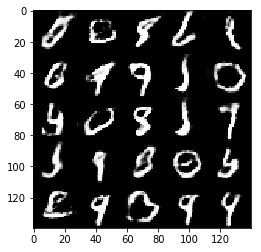

Epoch 0/2 S(D,G) 805(1.2539 0.6436) 810(1.2837 0.9302) 815(1.3115 0.6205) 820(1.3660 1.0211) 825(1.2007 0.7982) 830(1.3084 1.0946) 835(1.4066 0.4639) 840(1.2497 0.9715) 845(1.3294 0.6800) 850(1.3511 1.0738) 855(1.2786 0.7274) 860(1.4517 0.7721) 865(1.3195 0.7699) 870(1.3384 0.6374) 875(1.3628 0.9971) 880(1.3739 0.6892) 885(1.3980 0.5715) 890(1.2784 0.7933) 895(1.3921 0.5536) 900(1.2878 0.8791) 


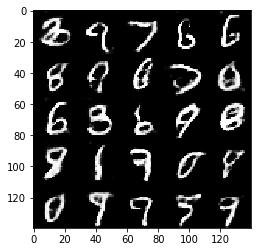

Epoch 0/2 S(D,G) 905(1.3087 0.7133) 910(1.3124 0.9443) 915(1.3633 0.5345) 920(1.2184 0.8493) 925(1.3328 0.5519) 930(1.3120 0.7056) 935(1.3125 0.9218) 940(1.3334 0.5926) 945(1.3706 1.1272) 950(1.3302 0.5591) 955(1.3395 0.8611) 960(1.3191 0.8226) 965(1.3050 0.5773) 970(1.2893 0.7643) 975(1.3415 0.7800) 980(1.2646 0.9801) 985(1.4464 0.4497) 990(1.2938 0.9605) 995(1.2744 0.7205) 1000(1.4579 0.4328) 


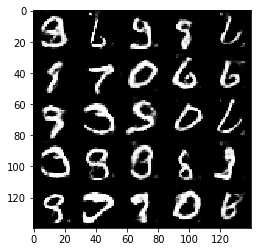

Epoch 1/2 S(D,G) 1005(1.2725 0.8821) 1010(1.2617 0.9457) 1015(1.3008 0.5839) 1020(1.2533 0.7038) 1025(1.4141 0.4820) 1030(1.2821 0.6922) 1035(1.3487 0.6908) 1040(1.3297 1.1549) 1045(1.2571 0.7236) 1050(1.2586 0.8025) 1055(1.2953 0.6445) 1060(1.3671 0.9745) 1065(1.2850 0.6862) 1070(1.3289 1.1786) 1075(1.6937 0.4767) 1080(1.4578 0.5502) 1085(1.3008 0.7437) 1090(1.3101 0.7528) 1095(1.2614 0.9494) 1100(1.3073 0.5389) 


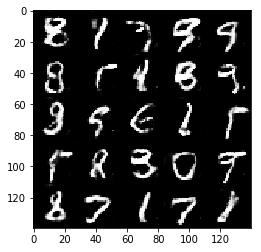

Epoch 1/2 S(D,G) 1105(1.3304 0.8780) 1110(1.2504 0.7195) 1115(1.2523 0.9406) 1120(1.2699 0.6802) 1125(1.2990 0.9150) 1130(1.3249 0.5912) 1135(1.3406 1.0434) 1140(1.2960 0.6135) 1145(1.3343 1.1624) 1150(1.3218 0.6181) 1155(1.3019 0.9694) 1160(1.5291 0.6688) 1165(1.3647 0.5857) 1170(1.3076 0.8666) 1175(1.2278 0.7496) 1180(1.3371 0.8965) 1185(1.3115 0.7486) 1190(1.2656 0.6842) 1195(1.3915 1.1389) 1200(1.3270 0.5683) 


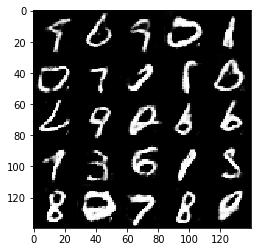

Epoch 1/2 S(D,G) 1205(1.2947 0.8848) 1210(1.2846 0.6629) 1215(1.3974 1.0370) 1220(1.2887 0.6002) 1225(1.2888 0.9609) 1230(1.3740 0.4922) 1235(1.3408 1.0451) 1240(1.2809 0.5724) 1245(1.2946 0.8504) 1250(1.3169 0.5399) 1255(1.3165 0.7919) 1260(1.3168 1.0845) 1265(1.3340 0.5495) 1270(1.3154 0.9028) 1275(1.2401 0.6971) 1280(1.3083 1.0089) 1285(1.3107 0.6564) 1290(1.3300 0.8574) 1295(1.2483 0.7831) 1300(1.2220 0.7873) 


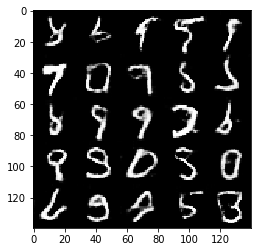

Epoch 1/2 S(D,G) 1305(1.3013 1.0456) 1310(1.3002 0.6208) 1315(1.3711 1.1822) 1320(1.1825 0.7649) 1325(1.3553 0.7221) 1330(1.3662 0.9522) 1335(1.4236 0.4634) 1340(1.3611 0.9677) 1345(1.2720 0.7557) 1350(1.2778 1.0046) 1355(1.2868 0.8000) 1360(1.3096 0.6038) 1365(1.2565 0.9417) 1370(1.2575 0.6721) 1375(1.3330 0.8071) 1380(1.4520 0.5113) 1385(1.4014 0.4980) 1390(1.3388 0.9984) 1395(1.2919 0.5571) 1400(1.3070 0.9984) 


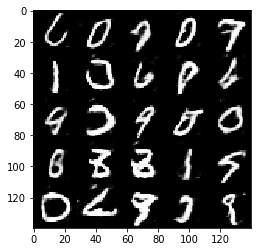

Epoch 1/2 S(D,G) 1405(1.2804 0.8998) 1410(1.3343 0.6068) 1415(1.3034 0.9007) 1420(1.3036 0.5972) 1425(1.3264 1.1199) 1430(1.3235 0.5587) 1435(1.4168 1.1945) 1440(1.3319 0.8432) 1445(1.2946 0.6498) 1450(1.2968 0.8244) 1455(1.2919 0.8500) 1460(1.4084 0.4460) 1465(1.2850 0.7038) 1470(1.2227 0.8174) 1475(1.3207 0.9592) 1480(1.3083 0.6144) 1485(1.2461 0.9833) 1490(1.3136 0.6553) 1495(1.4736 1.0962) 1500(1.4973 0.9871) 


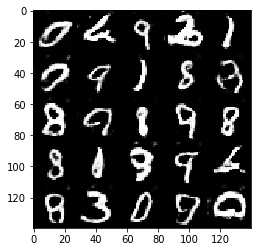

Epoch 1/2 S(D,G) 1505(1.3356 0.9916) 1510(1.3520 0.5958) 1515(1.3289 1.1168) 1520(1.3223 0.9104) 1525(1.3264 0.5433) 1530(1.2758 0.9640) 1535(1.2689 0.8019) 1540(1.2679 0.7337) 1545(1.2837 0.9752) 1550(1.2808 0.6445) 1555(1.2852 0.8732) 1560(1.2710 0.6231) 1565(1.2314 0.8267) 1570(1.2677 0.7351) 1575(1.3648 0.5728) 1580(1.2092 0.9824) 1585(1.2881 0.6008) 1590(1.4458 1.2465) 1595(1.2890 0.6298) 1600(1.3053 1.0896) 


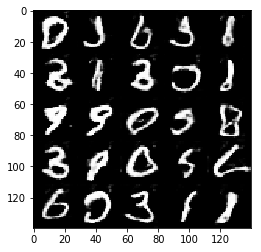

Epoch 1/2 S(D,G) 1605(1.3782 0.5897) 1610(1.2963 0.9465) 1615(1.2791 0.8821) 1620(1.4587 0.4490) 1625(1.3307 1.1055) 1630(1.2897 0.8653) 1635(1.3332 0.7799) 1640(1.2904 0.6367) 1645(1.2988 0.9535) 1650(1.2209 0.7757) 1655(1.3858 0.5068) 1660(1.3143 1.2326) 1665(1.4380 0.4860) 1670(1.3414 0.6734) 1675(1.3420 0.9581) 1680(1.3027 0.6670) 1685(1.2675 0.9427) 1690(1.3003 0.6352) 1695(1.3004 1.0224) 1700(1.2310 0.7595) 


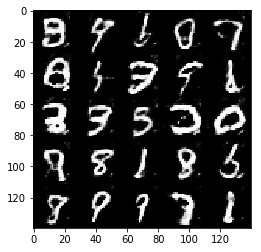

Epoch 1/2 S(D,G) 1705(1.2770 0.7563) 1710(1.2778 0.8321) 1715(1.2682 0.8927) 1720(1.2982 0.5140) 1725(1.3051 1.0107) 1730(1.2860 0.6492) 1735(1.2617 0.6901) 1740(1.3111 0.8644) 1745(1.2557 0.6039) 1750(1.5195 1.2940) 1755(1.2571 0.7011) 1760(1.2917 0.6372) 1765(1.2433 0.8137) 1770(1.3836 1.2340) 1775(1.2598 0.6407) 1780(1.2644 0.6351) 1785(1.2754 0.9630) 1790(1.3506 0.5362) 1795(1.3186 1.0642) 1800(1.4097 0.7605) 


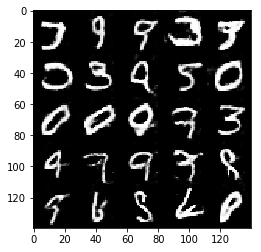

Epoch 1/2 S(D,G) 1805(1.2531 0.7605) 1810(1.2615 0.5767) 1815(1.2924 1.2177) 1820(1.4855 0.4307) 1825(1.2694 0.6862) 1830(1.4385 1.2588) 1835(1.3492 0.6087) 1840(1.2783 0.8677) 1845(1.2713 0.9381) 1850(1.3242 0.5348) 1855(1.3233 0.9567) 1860(1.2523 0.8581) 1865(1.5105 0.5365) 1870(1.2350 1.0651) Done!


In [42]:
batch_size = 64
z_dim = 100
learning_rate = 0.003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 0/1 S(D,G) 5(2.0302 1.0699) 10(2.1018 0.1663) 15(1.5222 1.3662) 20(1.2357 1.1609) 25(1.5553 0.4243) 30(1.4537 1.5530) 35(2.1313 0.1786) 40(1.5546 1.6400) 45(1.2151 1.2415) 50(2.0735 0.4365) 55(1.2813 0.9895) 60(1.0426 1.7464) 65(1.9265 0.5439) 70(1.2865 1.4844) 75(1.7010 0.8284) 80(1.2692 1.3306) 85(1.0430 1.4762) 90(1.3453 1.0723) 95(1.2342 1.1078) 100(0.6007 2.0005) 


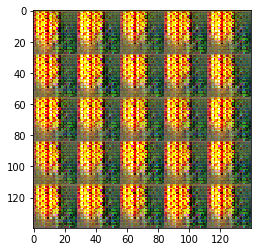

Epoch 0/1 S(D,G) 105(1.4764 0.5417) 110(1.6589 0.7088) 115(1.3283 0.6112) 120(0.6220 1.2968) 125(1.3109 1.0972) 130(1.6707 0.6463) 135(1.0190 1.1815) 140(1.4773 0.9975) 145(1.6515 0.5037) 150(1.4321 0.7096) 155(1.1476 0.7578) 160(1.1756 1.1658) 165(1.3271 0.5214) 170(2.2013 0.6231) 175(1.4188 0.4940) 180(1.3611 1.0061) 185(1.3256 0.9213) 190(1.2272 0.6556) 195(1.2073 1.1153) 200(1.6842 0.8955) 


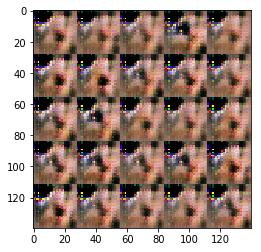

Epoch 0/1 S(D,G) 205(1.5700 0.8499) 210(1.3893 0.9571) 215(1.3876 0.5608) 220(1.2433 0.8149) 225(1.4377 0.7636) 230(1.4374 0.6866) 235(1.3613 0.7516) 240(1.3355 0.5615) 245(1.4229 1.1647) 250(1.4381 0.4697) 255(1.4084 0.8366) 260(1.3560 0.7892) 265(1.2978 0.7079) 270(1.3190 0.7253) 275(1.2741 0.7583) 280(1.4945 0.3685) 285(1.4794 0.9764) 290(1.9227 0.4928) 295(1.5616 1.1896) 300(1.3420 0.6165) 


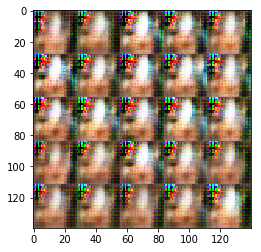

Epoch 0/1 S(D,G) 305(1.3182 0.8025) 310(1.3482 0.6282) 315(1.2698 0.7898) 320(1.2921 0.7242) 325(1.3125 0.7595) 330(1.3634 0.8600) 335(1.6023 0.6849) 340(1.3743 0.5516) 345(1.3731 0.8305) 350(1.2255 0.7384) 355(1.2785 0.8765) 360(1.4041 0.4649) 365(1.3718 1.0199) 370(1.3297 0.5608) 375(1.3320 0.7057) 380(1.3978 0.9166) 385(1.3716 0.6295) 390(1.3778 0.7598) 395(1.3227 0.7269) 400(1.3608 0.6302) 


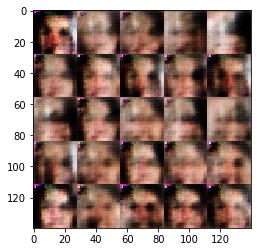

Epoch 0/1 S(D,G) 405(1.4031 0.8968) 410(1.3329 0.6459) 415(1.3479 0.6340) 420(1.3466 0.8042) 425(1.3399 0.5353) 430(2.9821 1.4519) 435(1.6753 1.4751) 440(1.7557 0.2815) 445(1.4914 1.0179) 450(1.5681 0.7510) 455(1.4358 0.7515) 460(1.4486 0.6938) 465(1.4005 0.7008) 470(1.4440 0.6198) 475(1.4408 0.8749) 480(1.3717 0.7416) 485(1.4806 0.7938) 490(1.3565 0.7331) 495(1.4427 0.5884) 500(1.4176 0.7994) 


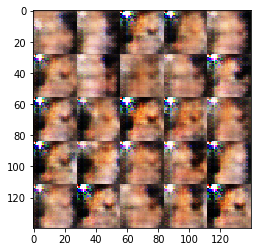

Epoch 0/1 S(D,G) 505(1.3678 0.7161) 510(1.4262 0.7643) 515(1.3510 0.6398) 520(1.3537 0.6902) 525(1.4002 0.8259) 530(1.3479 0.6309) 535(1.3306 0.7377) 540(1.3245 0.7217) 545(1.3854 0.7544) 550(1.3256 0.6577) 555(1.3525 0.7838) 560(1.3605 0.6724) 565(1.4157 0.7048) 570(1.3200 0.7816) 575(1.3718 0.6278) 580(1.3786 0.6932) 585(1.3265 0.7510) 590(1.3463 0.7130) 595(1.3594 0.6714) 600(1.4050 0.6141) 


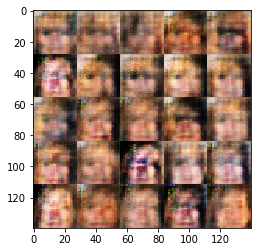

Epoch 0/1 S(D,G) 605(1.3606 0.8680) 610(1.3804 0.5537) 615(1.5842 0.6883) 620(1.8268 0.8767) 625(1.5995 0.9091) 630(1.4369 0.5870) 635(1.4092 0.7098) 640(1.4805 0.6583) 645(1.4201 0.6934) 650(1.3859 0.6968) 655(1.4331 0.8849) 660(1.3958 0.6580) 665(1.4071 0.7049) 670(1.4289 0.7168) 675(1.3803 0.6747) 680(1.4422 0.7260) 685(1.3970 0.6392) 690(1.3862 0.7205) 695(1.3576 0.7046) 700(1.3464 0.7045) 


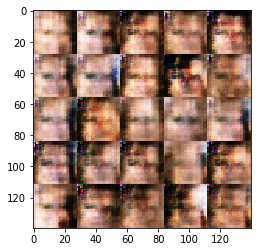

Epoch 0/1 S(D,G) 705(1.3598 0.7215) 710(1.3576 0.6644) 715(1.3443 0.7510) 720(1.3894 0.6236) 725(1.3408 0.7204) 730(1.3465 0.6887) 735(1.3460 0.7377) 740(1.3408 0.6742) 745(1.3652 0.7156) 750(1.3798 0.7039) 755(1.3222 0.7346) 760(1.3502 0.7205) 765(1.3277 0.6642) 770(1.3784 0.7501) 775(1.3389 0.6913) 780(1.3326 0.7384) 785(1.3749 0.6303) 790(1.3787 0.7308) 795(1.3537 0.6699) 800(1.3779 0.7003) 


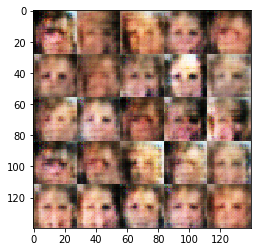

Epoch 0/1 S(D,G) 805(1.3741 0.6193) 810(1.3398 0.7217) 815(1.3975 0.6288) 820(1.3693 0.7152) 825(1.3690 0.6740) 830(1.3444 0.6912) 835(1.3506 0.6966) 840(1.3334 0.6781) 845(1.3536 0.7116) 850(1.3748 0.7182) 855(1.3742 0.5763) 860(1.3644 0.8355) 865(1.3651 0.6075) 870(1.3186 0.6955) 875(1.3391 0.6768) 880(1.3184 0.7967) 885(1.3938 0.6392) 890(1.8110 0.6325) 895(1.5877 0.8913) 900(1.5151 0.6882) 


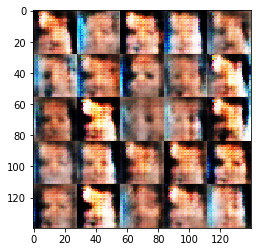

Epoch 0/1 S(D,G) 905(1.4324 0.7532) 910(1.5163 0.7393) 915(1.3793 0.7606) 920(1.4753 0.7305) 925(1.3460 0.7720) 930(1.3801 0.7085) 935(1.3700 0.6733) 940(1.3913 0.6758) 945(1.3755 0.7490) 950(1.3897 0.6854) 955(1.4198 0.8126) 960(1.3973 0.6734) 965(1.3673 0.6910) 970(1.4481 0.7713) 975(1.3795 0.6892) 980(1.3858 0.6936) 985(1.3829 0.6779) 990(1.3774 0.7094) 995(1.4135 0.6951) 1000(1.4038 0.6972) 


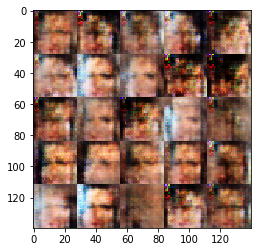

Epoch 0/1 S(D,G) 1005(1.3961 0.6678) 1010(1.3937 0.7067) 1015(1.4065 0.6607) 1020(1.4181 0.7627) 1025(1.4013 0.6253) 1030(1.3910 0.6922) 1035(1.3814 0.6726) 1040(1.3858 0.7256) 1045(1.3662 0.7091) 1050(1.3667 0.6951) 1055(1.3732 0.7007) 1060(1.4077 0.6465) 1065(1.3649 0.7257) 1070(1.3751 0.6694) 1075(1.3669 0.7327) 1080(1.3712 0.6626) 1085(1.3542 0.7300) 1090(1.3681 0.6773) 1095(1.3902 0.6893) 1100(1.4150 0.6529) 


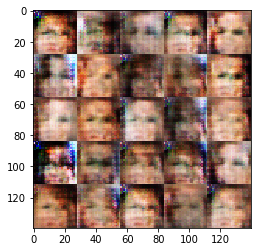

Epoch 0/1 S(D,G) 1105(1.3691 0.6876) 1110(1.3741 0.6690) 1115(1.3777 0.6902) 1120(1.3754 0.6907) 1125(1.3647 0.6734) 1130(1.3574 0.6960) 1135(1.3830 0.6298) 1140(1.3881 0.6996) 1145(1.3641 0.6876) 1150(1.3856 0.6391) 1155(1.3705 0.7133) 1160(1.3392 0.6675) 1165(1.3815 0.7029) 1170(1.3623 0.7229) 1175(1.3576 0.6611) 1180(1.3629 0.7004) 1185(1.3400 0.7311) 1190(1.3514 0.7143) 1195(1.3797 0.6966) 1200(1.3581 0.6819) 


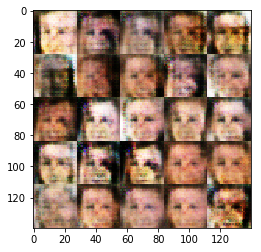

Epoch 0/1 S(D,G) 1205(1.3556 0.7030) 1210(1.3773 0.6414) 1215(1.3733 0.7269) 1220(1.3759 0.6412) 1225(1.3735 0.6539) 1230(1.3354 0.7379) 1235(1.3568 0.6738) 1240(1.3652 0.6379) 1245(1.3464 0.6597) 1250(1.3453 0.6814) 1255(1.3790 0.7431) 1260(1.3363 0.6917) 1265(1.3474 0.7132) 1270(1.3576 0.7280) 1275(1.3573 0.6411) 1280(1.3674 0.8154) 1285(1.3516 0.6538) 1290(1.3552 0.7453) 1295(1.3483 0.6271) 1300(1.3626 0.6885) 


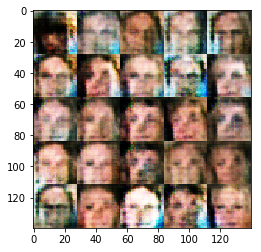

Epoch 0/1 S(D,G) 1305(1.3670 0.7709) 1310(1.4014 0.6349) 1315(1.3468 0.6919) 1320(1.3446 0.7861) 1325(1.3647 0.6270) 1330(1.3593 0.6995) 1335(1.3675 0.7203) 1340(1.3815 0.5947) 1345(1.3771 0.6922) 1350(1.4187 0.5755) 1355(1.3606 0.7382) 1360(1.3888 0.6847) 1365(1.3456 0.7025) 1370(1.3836 0.6948) 1375(1.3706 0.6297) 1380(1.3431 0.7508) 1385(1.3500 0.7412) 1390(1.4080 0.6476) 1395(1.3839 0.6713) 1400(1.3785 0.6365) 


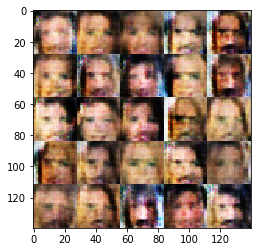

Epoch 0/1 S(D,G) 1405(1.3661 0.6804) 1410(1.3577 0.7189) 1415(1.4094 0.5840) 1420(1.3450 0.7355) 1425(1.3895 0.6002) 1430(1.3604 0.6921) 1435(1.3426 0.7217) 1440(1.3856 0.6511) 1445(1.3596 0.7200) 1450(1.3564 0.6605) 1455(1.3539 0.7031) 1460(1.3911 0.6339) 1465(1.3724 0.6462) 1470(1.3863 0.7001) 1475(1.3625 0.6554) 1480(1.3669 0.7623) 1485(1.3960 0.6091) 1490(1.3250 0.7671) 1495(1.4045 0.6623) 1500(1.3487 0.7148) 


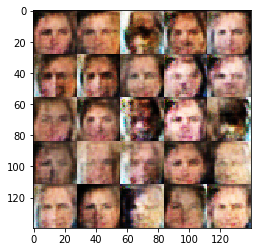

Epoch 0/1 S(D,G) 1505(1.3634 0.6879) 1510(1.3577 0.7848) 1515(1.3795 0.5977) 1520(1.3578 0.7596) 1525(1.3589 0.6407) 1530(1.3465 0.6782) 1535(1.3445 0.7412) 1540(1.3566 0.6048) 1545(1.3580 0.8455) 1550(1.3859 0.6239) 1555(1.3866 0.7443) 1560(1.3910 0.6029) 1565(1.3756 0.7623) 1570(1.3636 0.6948) 1575(1.3462 0.7042) 1580(1.3922 0.6694) 1585(1.3618 0.7199) 1590(1.4022 0.7238) 1595(1.3689 0.6713) 1600(1.3783 0.6581) 


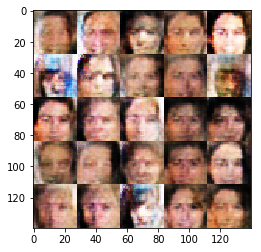

Epoch 0/1 S(D,G) 1605(1.3625 0.6493) 1610(1.3512 0.7712) 1615(1.3405 0.7100) 1620(1.3501 0.7083) 1625(1.3667 0.7532) 1630(1.3579 0.6645) 1635(1.3816 0.7235) 1640(1.3838 0.5991) 1645(1.3788 0.7244) 1650(1.3816 0.6522) 1655(1.3730 0.7139) 1660(1.3528 0.6194) 1665(1.4542 0.7256) 1670(1.3534 0.6825) 1675(1.3739 0.7138) 1680(1.3602 0.7419) 1685(1.3989 0.6617) 1690(1.3429 0.6703) 1695(1.3672 0.7181) 1700(1.3818 0.6320) 


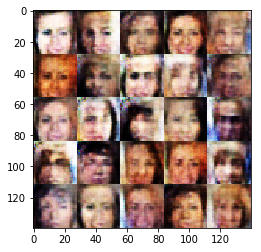

Epoch 0/1 S(D,G) 1705(1.3960 0.7455) 1710(1.3732 0.6954) 1715(1.4066 0.5340) 1720(1.3782 0.7918) 1725(1.3636 0.6178) 1730(1.3686 0.7070) 1735(1.3590 0.6821) 1740(1.3591 0.7259) 1745(1.4021 0.6126) 1750(1.3789 0.6861) 1755(1.3671 0.6816) 1760(1.3792 0.6555) 1765(1.3689 0.6603) 1770(1.4756 0.6567) 1775(2.4694 0.9972) 1780(1.6452 0.8234) 1785(1.3938 0.7645) 1790(1.4114 0.7031) 1795(1.3723 0.7233) 1800(1.3715 0.6967) 


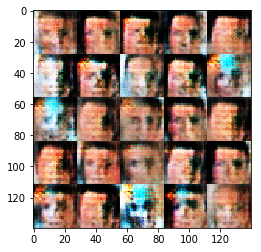

Epoch 0/1 S(D,G) 1805(1.4489 0.7280) 1810(1.4158 0.6985) 1815(1.3912 0.7050) 1820(1.3930 0.6900) 1825(1.3602 0.7253) 1830(1.3601 0.7073) 1835(1.4237 0.6912) 1840(1.3926 0.7035) 1845(1.3682 0.6933) 1850(1.3876 0.6842) 1855(1.4219 0.6845) 1860(1.4001 0.6656) 1865(1.3947 0.7167) 1870(1.3791 0.6864) 1875(1.3847 0.6940) 1880(1.3857 0.6920) 1885(1.3736 0.6921) 1890(1.4319 0.6909) 1895(1.4084 0.7040) 1900(1.4044 0.6821) 


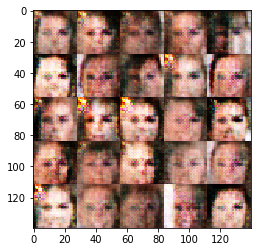

Epoch 0/1 S(D,G) 1905(1.3944 0.7099) 1910(1.3944 0.6702) 1915(1.4022 0.6964) 1920(1.3952 0.6884) 1925(1.3837 0.6941) 1930(1.3824 0.7022) 1935(1.3861 0.7089) 1940(1.3747 0.6936) 1945(1.3850 0.6810) 1950(1.4007 0.7042) 1955(1.3808 0.7074) 1960(1.3769 0.6929) 1965(1.3741 0.6955) 1970(1.3773 0.7058) 1975(1.3858 0.6859) 1980(1.3820 0.7099) 1985(1.3742 0.7067) 1990(1.4116 0.6767) 1995(1.3734 0.6986) 2000(1.3837 0.6947) 


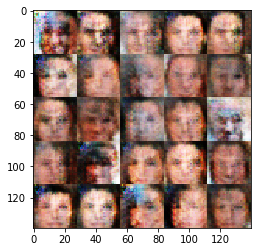

Epoch 0/1 S(D,G) 2005(1.3682 0.6810) 2010(1.3858 0.6809) 2015(1.3802 0.7025) 2020(1.3945 0.6942) 2025(1.3804 0.7012) 2030(1.3899 0.6850) 2035(1.3958 0.6885) 2040(1.3786 0.6967) 2045(1.3767 0.7043) 2050(1.3970 0.6907) 2055(1.3875 0.6862) 2060(1.3763 0.6940) 2065(1.3749 0.6728) 2070(1.3874 0.6835) 2075(1.3856 0.6887) 2080(1.3933 0.6728) 2085(1.3787 0.6896) 2090(1.3927 0.6962) 2095(1.3793 0.6912) 2100(1.3848 0.7010) 


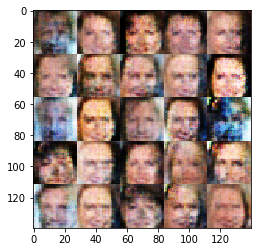

Epoch 0/1 S(D,G) 2105(1.3904 0.6860) 2110(1.3966 0.6791) 2115(1.3799 0.6915) 2120(1.3907 0.6893) 2125(1.3661 0.7010) 2130(1.3675 0.7059) 2135(1.3729 0.6840) 2140(1.3700 0.6902) 2145(1.3727 0.6849) 2150(1.3751 0.6907) 2155(1.3711 0.6809) 2160(1.3835 0.6739) 2165(1.3788 0.6970) 2170(1.3685 0.6960) 2175(1.3729 0.6905) 2180(1.3525 0.6993) 2185(1.3753 0.6954) 2190(1.3835 0.6795) 2195(1.3648 0.7065) 2200(1.3786 0.6853) 


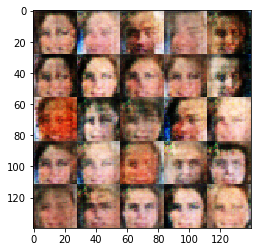

Epoch 0/1 S(D,G) 2205(1.3835 0.6813) 2210(1.3816 0.6707) 2215(1.3676 0.6859) 2220(1.3734 0.6858) 2225(1.3610 0.6831) 2230(1.3719 0.6772) 2235(1.3586 0.6906) 2240(1.3530 0.6945) 2245(1.3546 0.6935) 2250(1.3685 0.6825) 2255(1.3873 0.6819) 2260(1.3682 0.6796) 2265(1.3634 0.7029) 2270(1.3615 0.6832) 2275(1.3973 0.6642) 2280(1.3544 0.6963) 2285(1.3639 0.6678) 2290(1.3621 0.6848) 2295(1.3847 0.6680) 2300(1.3854 0.6722) 


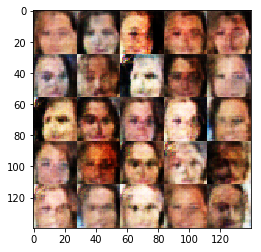

Epoch 0/1 S(D,G) 2305(1.3685 0.6848) 2310(1.3643 0.6894) 2315(1.3772 0.7073) 2320(1.3740 0.6839) 2325(1.3911 0.6972) 2330(1.3786 0.6733) 2335(1.3599 0.6748) 2340(1.3778 0.6696) 2345(1.3569 0.6759) 2350(1.3600 0.6954) 2355(1.3654 0.6818) 2360(1.3786 0.6865) 2365(1.3762 0.6542) 2370(1.3818 0.6522) 2375(1.3692 0.6654) 2380(1.4001 0.6561) 2385(1.3946 0.6551) 2390(1.3895 0.6742) 2395(1.3605 0.6753) 2400(1.3691 0.6708) 


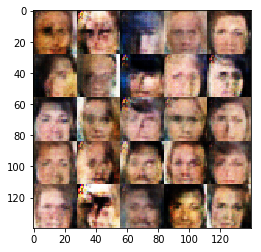

Epoch 0/1 S(D,G) 2405(1.3596 0.7231) 2410(1.3785 0.6944) 2415(1.3726 0.7126) 2420(1.3796 0.6891) 2425(1.3634 0.6733) 2430(1.3710 0.6926) 2435(1.3675 0.6825) 2440(1.3804 0.6837) 2445(1.3650 0.6648) 2450(1.3565 0.7214) 2455(1.3789 0.6864) 2460(1.3524 0.6985) 2465(1.3639 0.6879) 2470(1.3614 0.6821) 2475(1.3649 0.6981) 2480(1.3690 0.6667) 2485(1.3858 0.6225) 2490(1.3611 0.6482) 2495(1.3667 0.6997) 2500(1.3564 0.7002) 


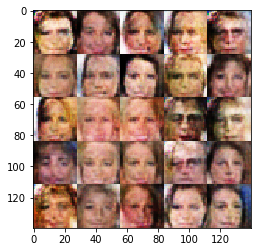

Epoch 0/1 S(D,G) 2505(1.3778 0.6526) 2510(1.3435 0.6713) 2515(1.4414 0.6951) 2520(2.0710 0.5307) 2525(1.3991 0.6984) 2530(1.4052 0.6766) 2535(1.5289 0.7942) 2540(1.4062 0.7096) 2545(1.4018 0.7184) 2550(1.3874 0.7109) 2555(1.3951 0.7149) 2560(1.3958 0.7236) 2565(1.3973 0.6887) 2570(1.3634 0.7080) 2575(1.4300 0.6893) 2580(1.3905 0.6948) 2585(1.3832 0.7072) 2590(1.3781 0.6795) 2595(1.3594 0.6842) 2600(1.3739 0.6842) 


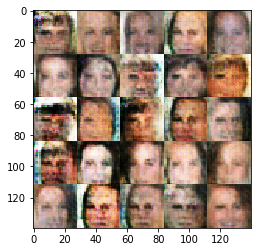

Epoch 0/1 S(D,G) 2605(1.3563 0.6848) 2610(1.3633 0.6941) 2615(1.3427 0.6908) 2620(1.3857 0.6660) 2625(1.3736 0.6910) 2630(1.3470 0.6891) 2635(1.3538 0.6955) 2640(1.3652 0.6916) 2645(1.3648 0.6915) 2650(1.3591 0.6956) 2655(1.3425 0.7002) 2660(1.3618 0.6867) 2665(1.3852 0.6672) 2670(1.3686 0.6578) 2675(1.3735 0.6672) 2680(1.3561 0.6610) 2685(1.3819 0.6750) 2690(1.3684 0.6651) 2695(1.3893 0.6847) 2700(1.3685 0.6530) 


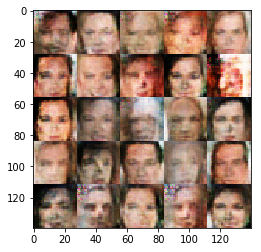

Epoch 0/1 S(D,G) 2705(1.3656 0.6854) 2710(1.3565 0.6615) 2715(1.3502 0.7028) 2720(1.3461 0.7050) 2725(1.3677 0.6812) 2730(1.3558 0.6791) 2735(1.3992 0.6341) 2740(1.3615 0.6788) 2745(1.3339 0.6752) 2750(1.3465 0.6796) 2755(1.3779 0.6755) 2760(1.3721 0.7104) 2765(1.3743 0.6839) 2770(1.3711 0.6551) 2775(1.3577 0.6633) 2780(1.3534 0.6793) 2785(1.3723 0.6669) 2790(1.3989 0.6726) 2795(1.3678 0.7157) 2800(1.3805 0.6886) 


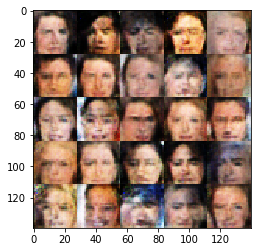

Epoch 0/1 S(D,G) 2805(1.3806 0.6571) 2810(1.3734 0.6661) 2815(1.3722 0.6629) 2820(1.4305 0.6782) 2825(1.7399 0.6206) 2830(1.3601 0.7063) 2835(1.3830 0.6882) 2840(1.4038 0.7145) 2845(1.4058 0.7019) 2850(1.3760 0.7127) 2855(1.3789 0.6971) 2860(1.3988 0.6931) 2865(1.3738 0.6897) 2870(1.4146 0.7282) 2875(1.4080 0.6817) 2880(1.3968 0.7012) 2885(1.4266 0.7101) 2890(1.3963 0.6649) 2895(1.3886 0.6852) 2900(1.3859 0.6783) 


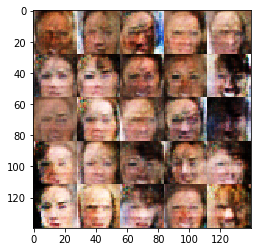

Epoch 0/1 S(D,G) 2905(1.3903 0.6860) 2910(1.3863 0.7072) 2915(1.3863 0.7030) 2920(1.3873 0.6692) 2925(1.3785 0.6900) 2930(1.3857 0.6891) 2935(1.3631 0.7080) 2940(1.3950 0.6680) 2945(1.3841 0.6837) 2950(1.3854 0.6830) 2955(1.3678 0.6896) 2960(1.3800 0.6641) 2965(1.3929 0.6678) 2970(1.3433 0.6996) 2975(1.3835 0.6757) 2980(1.3692 0.6841) 2985(1.3844 0.6877) 2990(1.3684 0.6825) 2995(1.3846 0.6712) 3000(1.3749 0.6897) 


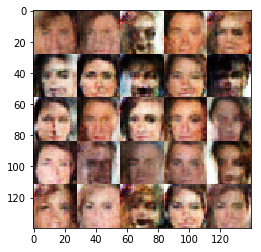

Epoch 0/1 S(D,G) 3005(1.3720 0.6838) 3010(1.3674 0.6914) 3015(1.3662 0.6947) 3020(1.3802 0.6694) 3025(1.3693 0.6827) 3030(1.3780 0.6770) 3035(1.3757 0.6707) 3040(1.3474 0.7088) 3045(1.3645 0.6859) 3050(1.3632 0.6982) 3055(1.3696 0.6924) 3060(1.3861 0.6768) 3065(1.3823 0.6569) 3070(1.3479 0.7062) 3075(1.3854 0.6287) 3080(1.3706 0.6603) 3085(1.3882 0.7124) 3090(1.3851 0.6393) 3095(1.3435 0.6994) 3100(1.3774 0.6778) 


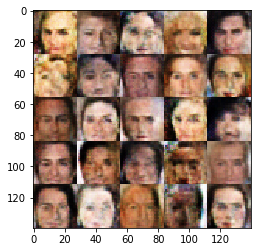

Epoch 0/1 S(D,G) 3105(1.3747 0.6808) 3110(1.3786 0.6645) 3115(1.3765 0.6919) 3120(1.3665 0.7046) 3125(1.3861 0.6563) 3130(1.3658 0.7124) 3135(1.3623 0.6959) 3140(1.3561 0.6827) 3145(1.3600 0.6694) 3150(1.3759 0.7263) 3155(1.3767 0.6586) 3160(1.4176 0.6251) 3165(1.3629 0.6800) Done!


In [43]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.02


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。